In [1]:
# This is a notebook to test out the splicing of library correlations into a covariance matrix
# of uncertainties for a cpox mechanism

In [1]:
import os
import sys
import pickle
import copy
import numpy as np
import rmgpy.chemkin
import rmgpy.tools.uncertainty
import rmgpy.kinetics.uncertainties

import rmgpy.tools.canteramodel
import random

import rmgpy.kinetics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the model

# Must use annotated chemkin file
chemkin_file = '/home/moon/uncertainty_estimator/beef/cpox_Pt/chem_annotated-gas.inp'
mech_dir = os.path.dirname(chemkin_file)
dict_file = '/home/moon/uncertainty_estimator/beef/cpox_Pt/species_dictionary.txt'
surface = '/home/moon/uncertainty_estimator/beef/cpox_Pt/chem_annotated-surface.inp'

uncertainty = rmgpy.tools.uncertainty.Uncertainty(output_directory=os.path.join(mech_dir, 'rmg_uncertainty'))


# Run Gao estimation of input parameters (takes a long time to load database)
uncertainty = rmgpy.tools.uncertainty.Uncertainty(output_directory='uncertainty_calculations')
uncertainty.load_model(chemkin_file, dict_file, surface_path=surface)

In [3]:
# --------------- CAUTION!!! Databases here must match the ones used to generate the mechanism
thermo_libs = [
    'surfaceThermoPt111',
    'primaryThermoLibrary',
    'thermo_DFT_CCSDTF12_BAC',
    'DFT_QCI_thermo'
]
kinetic_libs = [
    'Surface/CPOX_Pt/Deutschmann2006_adjusted',
    'BurkeH2O2inArHe'
]

kinetics_families = [
    'default',
    'Surface_Adsorption_Single',
    'Surface_Adsorption_vdW',
    'Surface_Adsorption_Dissociative',
    'Surface_Dissociation',
    'Surface_Abstraction',
    'Surface_Dissociation_Double_vdW',
    'Surface_Dissociation_vdW',
    'Surface_Abstraction_vdW',
    'Surface_Dissociation_Beta',
    'Surface_Adsorption_Bidentate',
    'Surface_Bidentate_Dissociation',
    'Surface_Monodentate_to_Bidentate',
    'Surface_Dissociation_to_Bidentate', 
    'Surface_vdW_to_Bidentate',
    'Surface_Adsorption_Dissociative_Double',
    'Surface_Abstraction_Beta',
    # 'Surface_Abstraction_Beta_double_vdW',
    'Surface_Dissociation_Double',
    'Surface_Dissociation_Beta_vdW',
    'Surface_Abstraction_Beta_vdW',
    'Surface_Abstraction_Single_vdW',
]


In [4]:
uncertainty.load_database(
    thermo_libraries=thermo_libs,
    kinetics_families=kinetics_families,
    reaction_libraries=kinetic_libs,
)

ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.2599,68.0494,74.7775,80.9311,90.8846,97.4337,105.393],'J/(mol*K)'), H298=(-477.191,'kJ/mol'), S298=(269.551,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(103.931,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)(Cds-Cd)) + group(O2s-(Cds-O2d)H) + group(Cds-OdOsOs) + group(Li-OCOdO) + radical(OC=OOJ)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for Entropy calculationat T = 2000.0 K...
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.2599,68.0494,74.7775,80.9311,90.8846,97.4337,105.393],'J/(mol*K)'), H298=(-477.191,'kJ/mol'), S298=(269.551,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(103.931,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)(Cds-Cd)) + group(O2s-(Cds-O2d)H) + group(Cds-OdOsOs) + group(Li-OCOdO) + radical(OC=OOJ)""").
The thermo for this species is probably wrong! Setting CpInf = Cphigh for En

# uncorrelated

In [5]:
# Get the different kinetic and thermo sources
uncertainty.extract_sources_from_model()
uncertainty.assign_parameter_uncertainties()

In [10]:
np.save(os.path.join(mech_dir, 'gao_reaction_uncertainty.npy'), uncertainty.kinetic_input_uncertainties)
np.save(os.path.join(mech_dir, 'gao_species_uncertainty.npy'), uncertainty.thermo_input_uncertainties)

# correlated

In [6]:
uncertainty.extract_sources_from_model()
uncertainty.assign_parameter_uncertainties(correlated=True)

In [7]:
cov_thermo = uncertainty.get_thermo_covariance_matrix()

Text(0, 0.5, 'Surface Species                    Gas Species')

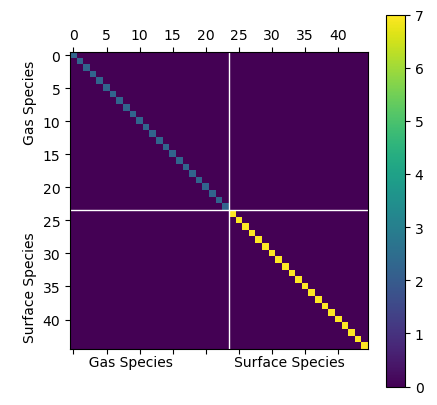

In [18]:
plt.matshow(cov_thermo)
plt.colorbar()
# plt.clim([-10, 50])
plt.clim([0, 7.0])

N_spec = len(uncertainty.species_list)
N_rxn = len(uncertainty.reaction_list)
N_total = N_spec + N_rxn

divider1 = np.argmax([x.contains_surface_site() for x in uncertainty.species_list]) - 0.5

plt.axvline(x=divider1, color='w', linewidth=1.0)
plt.axhline(y=divider1, color='w', linewidth=1.0)

plt.xlabel('                  Gas Species              Surface Species                   ')
plt.ylabel('Surface Species                    Gas Species')


In [6]:
# can just add to it after the fact?

# species dictionary does not preserve order, do not use it
# # load the saved cov matrix
lib_cov = np.load('surfaceThermoPt111_covarance.npy')  # units here are (kJ/mol)^2
# lib_spec = rmgpy.chemkin.load_species_dictionary('lib_spec_dict.txt')
# lib_spec = [lib_spec[key] for key in lib_spec.keys()]

In [7]:
with open('my_mol_list.pickle', 'rb') as f:
    mol_list = pickle.load(f)
my_species = [rmgpy.species.Species().from_adjacency_list(mol) for mol in mol_list]
assert len(my_species) == lib_cov.shape[0]

In [8]:
def get_i_thing(thing, thing_list):
    for i in range(len(thing_list)):
        if thing.is_isomorphic(thing_list[i]):
            return i
    return -1

In [9]:
def get_covariance(sp1, sp2):
    i1 = get_i_thing(sp1, my_species)
    if i1 < 0:
        return 0
    i2 = get_i_thing(sp2, my_species)
    if i2 < 0:
        return 0
    
    # covariance of lib is given in (kJ/mol) ^2
    return lib_cov[i1, i2] / 4.184 / 4.814  # to convert to kcal/mol

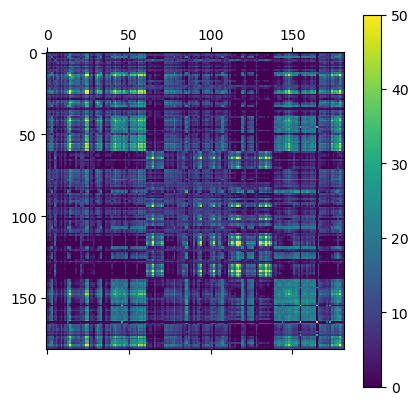

In [16]:
plt.matshow(lib_cov / 4.184 / 4.814)
plt.colorbar()
plt.clim([0, 50])

# Find most correlated species in library

In [21]:
other_cov = copy.deepcopy(lib_cov / 4.184 / 4.814)
for i in range(other_cov.shape[0]):
    other_cov[i, i]=0


In [26]:
my_species[0].molecule[0].smiles

'C=C=C.[Pt]'

In [38]:
lib_cov[81, 81] / 4.184 / 4.814

7.022620074448853

81

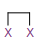

In [37]:
i = get_i_thing(rmgpy.species.Species(smiles='CC.*'), my_species)
i = get_i_thing(rmgpy.species.Species(smiles='CC*'), my_species)
i = get_i_thing(rmgpy.species.Species(smiles='C=C*'), my_species)
i = get_i_thing(rmgpy.species.Species(smiles='*CC*'), my_species)
display(i, my_species[i])

In [30]:
my_species[10]

In [28]:
for i in range(len(my_species)):
    if my_species[i].contains_surface_site():
        covs = other_cov[i, :]
        max_cov = 0
        max_j = -1
        for j in range(len(my_species)):
            if 'N' not in my_species[j].smiles and covs[j] > max_cov:
                max_cov = covs[j]
                max_j = j
        print(other_cov[i, max_j], '\t', my_species[i], '\t', my_species[max_j])

14.88431197174236 	 C=C=C.[Pt] 	 COCO[Pt]
15.22489201925916 	 C=C.[Pt] 	 COCO[Pt]
17.627041880270465 	 C=C=O.[Pt] 	 COCO[Pt]
11.827103350106034 	 C=N.[Pt] 	 [Pt]OO[Pt]
23.469028557557643 	 C=O.[Pt] 	 COCO[Pt]
24.380228875521766 	 C=C(C)[Pt] 	 [Pt]#CCC#[Pt]
21.826612479248777 	 C=C(O)[Pt] 	 COCO[Pt]
19.67140924503587 	 CCC.[Pt] 	 COCO.[Pt]
7.91113838449816 	 CCO.[Pt] 	 COCO[Pt]
26.250059979922685 	 CCC(=O)[Pt] 	 COCO[Pt]
13.170299949388616 	 CC.[Pt] 	 COCO.[Pt]
19.450622098729994 	 C=CC.[Pt] 	 COCO[Pt]
19.43673883647699 	 CC=O.[Pt] 	 COCO.[Pt]
17.043243541150005 	 CN.[Pt] 	 COCO[Pt]
42.16398606233982 	 [N-]([N+](=[Pt])O)C 	 COCO[Pt]
36.67763976401773 	 COCO.[Pt] 	 COCO[Pt]
30.750011154062392 	 COC.[Pt] 	 COCO[Pt]
24.848900196674133 	 CO.[Pt] 	 COCO[Pt]
23.502941823341864 	 CC(C)=[Pt] 	 COCO[Pt]
26.337413927365777 	 CC(C)[Pt] 	 COCO[Pt]
27.794944316199025 	 CC(O)[Pt] 	 COCO[Pt]
13.47661228769656 	 CC([Pt])C[Pt] 	 [Pt]=CCC=[Pt]
21.9657624736365 	 CC(O)=[Pt] 	 COCO[Pt]
21.185606061819218 	

In [15]:
np.sum(lib_cov < 0)

4912

In [16]:
lib_cov.shape

(182, 182)

In [17]:
182 * 182

33124

In [14]:
new_cov_matrix = copy.deepcopy(cov_thermo)

for i in range(len(uncertainty.species_list)):
    for j in range(i):
        cov = get_covariance(uncertainty.species_list[i], uncertainty.species_list[j])
        new_cov_matrix[i, j] += cov
        new_cov_matrix[j, i] += cov

Text(0, 0.5, 'Surface Species                    Gas Species')

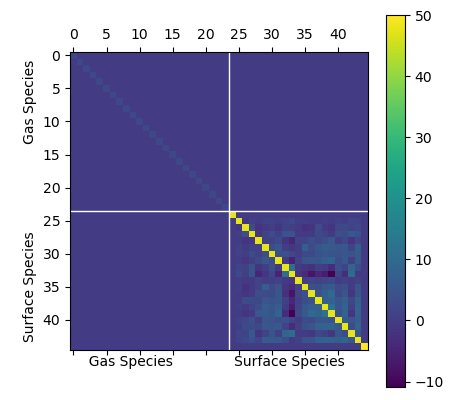

In [15]:
plt.matshow(new_cov_matrix)
plt.colorbar()


N_spec = len(uncertainty.species_list)
N_rxn = len(uncertainty.reaction_list)
N_total = N_spec + N_rxn

divider1 = np.argmax([x.contains_surface_site() for x in uncertainty.species_list]) - 0.5

plt.axvline(x=divider1, color='w', linewidth=1.0)
plt.axhline(y=divider1, color='w', linewidth=1.0)

plt.xlabel('                  Gas Species              Surface Species                   ')
plt.ylabel('Surface Species                    Gas Species')
# plt.clim([-40, 40])

In [21]:
uncertainty.thermo_covariance_matrix = new_cov_matrix

In [22]:
uncertainty.get_kinetic_covariance_matrix()

array([[ 0.25      ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.25      ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.25      , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 14.03343577,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        14.03343577, 13.78343577],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        13.78343577, 14.03343577]])

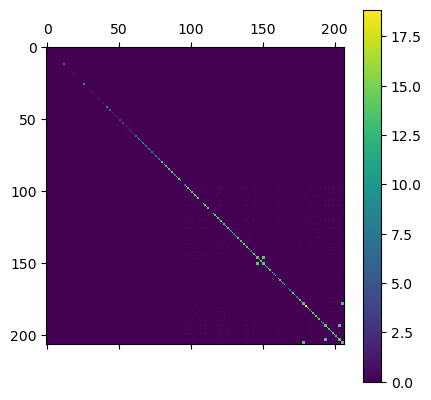

In [23]:
plt.matshow(uncertainty.kinetic_covariance_matrix)
plt.colorbar()

In [24]:
plt.matshow(uncertainty.get_overall_covariance_matrix())
plt.colorbar()

IndexError: list index out of range

In [25]:
M = new_cov_matrix.shape[0]
N = uncertainty.kinetic_covariance_matrix.shape[0]


overall_uncertainty = np.zeros((M + N, M + N))
overall_uncertainty[:M, :M] = new_cov_matrix
overall_uncertainty[M:, M:] = uncertainty.kinetic_covariance_matrix

In [27]:
np.save('overall_uncertainty_kcal2mol2.npy', overall_uncertainty)

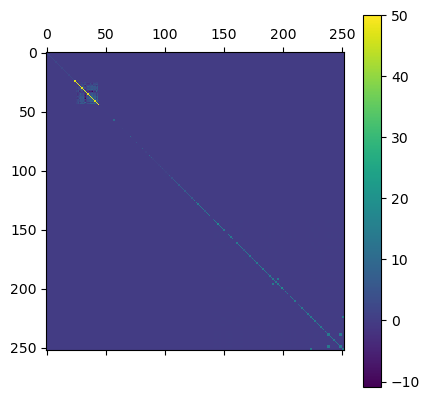

In [26]:
plt.matshow(overall_uncertainty)
plt.colorbar()

In [20]:
np.save('cpox_sampling_thermo_cov_kcal2mol2.npy', new_cov_matrix)

In [76]:
max_cov = 0
best_index = [-1, -1]
for i in range(new_cov_matrix.shape[0]):
    for j in range(i):
        if abs(new_cov_matrix[i, j]) > max_cov:
            max_cov = abs(new_cov_matrix[i, j])
            best_index = [i, j]

In [79]:
np.sqrt(new_cov_matrix[39, 38])

3.4404396594416506

In [77]:
best_index

[39, 38]

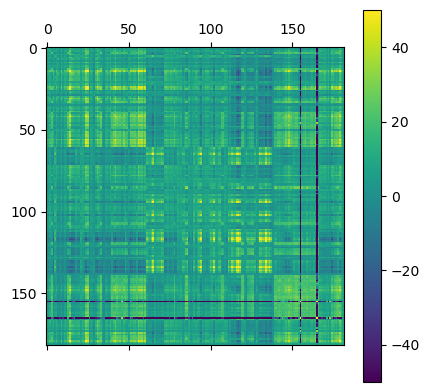

In [68]:
plt.matshow(lib_cov / 4.184 / 4.814)
plt.colorbar()
plt.clim([-50, 50])

In [28]:
uncertainty.species_list[24]